### Setup and Configuration

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, roc_auc_score, precision_recall_curve)
from joblib import dump
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Set paths
DATA_PATH = os.path.join('assets', 'data', 'SMSSpamCollection')
MODELS_PATH = os.path.join('assets', 'models')
os.makedirs(MODELS_PATH, exist_ok=True)

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Enhanced Text Preprocessing with Lemmatization
lemmatizer = WordNetLemmatizer()

### Load the Dataset

In [4]:
DATA_PATH = '/content/SMSSpamCollection.tsv'

In [5]:
df = pd.read_csv(DATA_PATH, sep='\t', header=None, names=['label', 'message'])
print("Dataset shape:", df.shape)

Dataset shape: (5572, 2)


In [6]:
print("First 5 samples:")
display(df.head())

First 5 samples:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
print("Dataset info:")
display(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


None

In [8]:
print("Label distribution:")
display(df['label'].value_counts())

Label distribution:


,count
label,
ham,4825
spam,747


* We have 5,572 total messages

* The dataset is highly imbalanced with 4,825 ham (non-spam) messages vs. 747 spam messages

* Messages contain a mix of proper English and informal/slang language

In [9]:
# Display random samples from each class
print("=== Ham Sample ===")
ham_sample = df[df['label'] == 'ham'].sample(1, random_state=RANDOM_SEED)['message'].values[0]
print(ham_sample)

print("\n=== Spam Sample ===")
spam_sample = df[df['label'] == 'spam'].sample(1, random_state=RANDOM_SEED)['message'].values[0]
print(spam_sample)

=== Ham Sample ===
If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.

=== Spam Sample ===
Summers finally here! Fancy a chat or flirt with sexy singles in yr area? To get MATCHED up just reply SUMMER now. Free 2 Join. OptOut txt STOP Help08714742804


Text Analysis:
* Case Sensitivity: Mixed case usage (both upper and lower)

* Punctuation: Present in most messages (periods, commas, etc.)

* Special Characters: Some messages have symbols and numbers

* Stopwords: Common words like "I", "the", "and" appear frequently

* Informal Language: Contractions ("I'm"), abbreviations ("aft" for after)

* URLs/Phone Numbers: Potential presence in spam messages

### Preprocessing

In [10]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize and lemmatize
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Join back to single string
    text = ' '.join(words)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


Applying Preprocessing to Dataset

In [11]:
df['processed_message'] = df['message'].apply(preprocess_text)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [12]:
# Show before/after samples
print("=== Before Preprocessing ===")
display(df[['message']].head(2))
print("\n=== After Preprocessing ===")
display(df[['processed_message']].head(2))

=== Before Preprocessing ===


,message
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...



=== After Preprocessing ===


,processed_message
0,go jurong point crazy available bugis n great ...
1,ok lar joking wif u oni


### Bag-of-Words Representation

In [13]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Using both unigrams and bigrams
    stop_words='english'
)

# Fit and transform the processed messages
X = vectorizer.fit_transform(df['processed_message'])
y = df['label']

# Show the shape of our feature matrix
print("Feature matrix shape:", X.shape)
print("Number of unique words:", len(vectorizer.get_feature_names_out()))

Feature matrix shape: (5572, 5000)
Number of unique words: 5000


In [14]:
# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set size: 4457
Test set size: 1115

Class distribution in training set:
label
0    0.865829
1    0.134171
Name: proportion, dtype: float64

Class distribution in test set:
label
0    0.866368
1    0.133632
Name: proportion, dtype: float64


In [15]:
# Using class weighting to handle imbalance
model = MultinomialNB(class_prior=[0.5, 0.5])  # Equal class priors

# Train model
model.fit(X_train, y_train)

# Predict on training set for initial check
train_preds = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9789


In [16]:
y_probs = model.predict_proba(X_test)[:, 1]

# Use optimal threshold based on precision-recall tradeoff
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Apply optimal threshold
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

## Comprehensive Evaluation
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_optimal):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal, target_names=['ham', 'spam']))

Test Accuracy: 0.9821

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.96      0.90      0.93       149

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



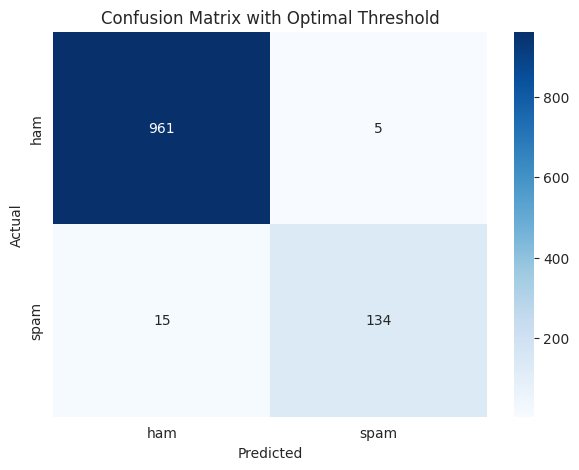

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix with Optimal Threshold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

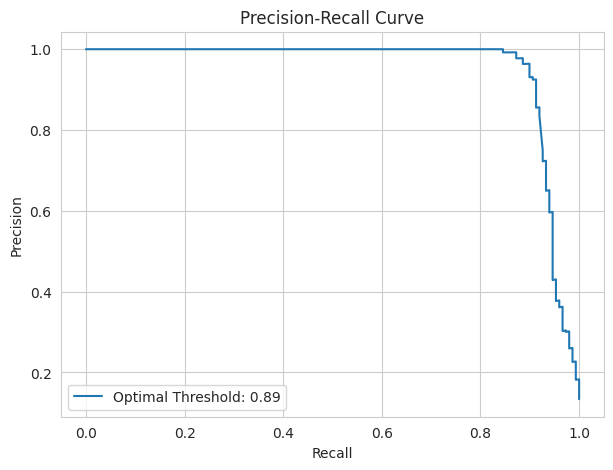

In [18]:
# Precision-Recall Curve
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

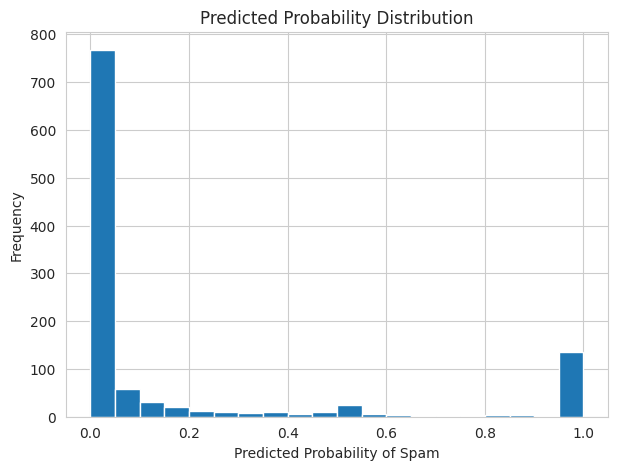

In [19]:
# Show probability distribution
plt.figure(figsize=(7,5))
plt.hist(y_probs, bins=20)
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Probability of Spam')
plt.ylabel('Frequency')
plt.show()

In [23]:
# Save the trained model
model_filename = os.path.join(MODELS_PATH, 'spam_model.joblib')
dump(model, model_filename)
print(f"Model saved to {model_filename}")

# Save the fitted vectorizer as well, as it's needed for inference
vectorizer_filename = os.path.join(MODELS_PATH, 'bow_vectorizer.joblib')
dump(vectorizer, vectorizer_filename)
print(f"Vectorizer saved to {vectorizer_filename}")

Model saved to assets/models/spam_model.joblib
Vectorizer saved to assets/models/bow_vectorizer.joblib
